In [1]:
import os
os.chdir('/home/megatron/work')

import megatron
import pandas as pd
import numpy as np
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Input, Add
from keras import losses, optimizers
from keras.models import Model
import pickle
import sqlite3

Using TensorFlow backend.


In [2]:
inputs = {'X1': Input((48, 48, 1)),
          'X2': Input((48, 48, 1))}
mid_outputs = {}

for input_name, input_node in inputs.items():
    X = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(48, 48, 1))(input_node)
    X = Conv2D(64, (3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(2, activation='softmax')(X)
    mid_outputs[input_name] = X
    
output = Add()([mid_outputs['X1'], mid_outputs['X2']])

model = Model(list(inputs.values()), output)

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [3]:
data = {'image1': np.random.random((1000, 48, 48, 3)),
        'image2': np.random.random((1000, 48, 48, 3)),
        'labels': np.random.randint(0, 1, 1000)}

bw_layer = megatron.layers.RGBtoGrey(method='luminosity', keep_dim=True)

images1 = megatron.nodes.Input('image1', shape=(48, 48, 3))
bw_images1 = bw_layer(images1, 'bw_images')

images2 = megatron.nodes.Input('image2', shape=(48, 48, 3))
bw_images2 = bw_layer(images2, 'bw_images')

labels_in = megatron.nodes.Input('labels')
labels = megatron.layers.OneHot(max_val=1)(labels_in, 'ohe_labels')

preds = megatron.layers.Keras(model)([bw_images1, bw_images2, labels], 'predictor')

pipeline = megatron.Pipeline([images1, images2, labels_in], preds, 
                          name='testkeras', version=0.1,
                          storage=sqlite3.connect('megatron_default'))

In [4]:
predictions = pipeline.transform(data)

In [6]:
predictions['predictor'].shape

(1000, 2)

In [7]:
pipeline.storage.read(lookup=['0'])['predictor'].shape

(1, 2)

In [6]:
pipeline.save('test')

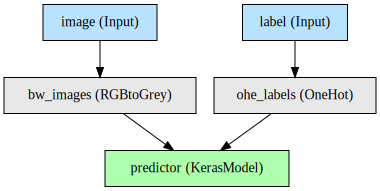

In [4]:
megatron.visuals.pipeline_imsave(pipeline, 'img/keras.png')
megatron.visuals.pipeline_imshow(pipeline)